Notebook for initial development and testing for synthesizing FA models.

The user specifies a number of individuals we observe data from.  For each of these individuals, we create a random number of observed variables (e.g., neurons) and associate with each of these variables some random properties (e.g., position or genetic information) generated uniformly from the unit square. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.decomposition
import torch

from janelia_core.math.basic_functions import optimal_orthonormal_transform
from janelia_core.ml.torch_distributions import CondGaussianDistribution
from janelia_core.ml.torch_distributions import CondGammaDistribution
from janelia_core.ml.extra_torch_modules import ConstantBoundedFcn
from janelia_core.ml.extra_torch_modules import Tanh
from janelia_core.visualization.image_generation import generate_2d_fcn_image
from janelia_core.visualization.matrix_visualization import cmp_n_mats
from janelia_core.ml.utils import list_torch_devices
from janelia_core.ml.utils import torch_mod_to_fcn

from probabilistic_model_synthesis.fa import FAMdl
from probabilistic_model_synthesis.fa import Fitter
from probabilistic_model_synthesis.fa import generate_basic_posteriors
from probabilistic_model_synthesis.fa import generate_hypercube_prior_collection
from probabilistic_model_synthesis.fa import generate_simple_prior_collection
from probabilistic_model_synthesis.fa import VICollection
from probabilistic_model_synthesis.math import MeanFcnTransformer
from probabilistic_model_synthesis.math import StdFcnTransformer
from probabilistic_model_synthesis.visualization import plot_torch_dist

## Parameters go here

In [4]:
# Number of individuals we simulate observing data from 
n_individuals = 5

# Range of the number of variables we observe from each individual - the actual number of variables we observe from an
# individual will be pulled uniformly from this range (inclusive)
n_var_range = [10000, 12000]

# Range of the number of samples we observe from each individual - the actual number we observe from each individual
# will be unformly from this range (inclusive)
n_smps_range = [1000, 1500]

# Number of latent variables in the model
n_latent_vars = 3

# True if we should use GPUs for fitting if they are available
use_gpus = True

## Create the true prior distributions that relate parameters in the model to variable (e.g., neuron) properties

In [5]:
true_priors = generate_simple_prior_collection(n_prop_vars=2, n_latent_vars=n_latent_vars, 
                                               lm_mn_w_init_std=1.0, lm_std_w_init_std=.1,
                                               mn_mn_w_init_std=1.0, mn_std_w_init_std=1.0,
                                               psi_conc_f_w_init_std=2.0, psi_rate_f_w_init_std=1.0, 
                                               psi_conc_bias_mn=10.0, psi_rate_bias_mn=5.0)

## Generate properties

In [6]:
ind_n_vars = np.random.randint(n_var_range[0], n_var_range[1]+1, n_individuals)
ind_n_smps = np.random.randint(n_smps_range[0], n_smps_range[1]+1, n_individuals)
ind_props = [torch.rand(size=[n_vars,2]) for n_vars in ind_n_vars]

## Generate true FA models

In [7]:
with torch.no_grad():
    ind_true_fa_mdls = [FAMdl(lm=true_priors.lm_prior.sample(props), mn=true_priors.mn_prior.sample(props).squeeze(), 
                           psi=(true_priors.psi_prior.sample(props).squeeze()))
                        for props in ind_props]

## Generate data from each model

In [8]:
with torch.no_grad():
    ind_data = [mdl.sample(n_smps) for n_smps, mdl in zip(ind_n_smps, ind_true_fa_mdls)]

## Fit new models together

In [9]:
fit_priors = generate_hypercube_prior_collection(n_latent_vars=n_latent_vars, 
                                                 hc_params={'n_divisions_per_dim': [40, 40], 
                                                            'dim_ranges': np.asarray([[0, 1.1], [0, 1.1]]), 
                                                            'n_div_per_hc_side_per_dim': [2, 2]})

fit_posteriors = generate_basic_posteriors(n_obs_vars=ind_n_vars, n_smps=ind_n_smps, n_latent_vars=n_latent_vars)

fit_mdls = [FAMdl(lm=None, mn=None, psi=None) for i in range(n_individuals)]

vi_collections = [VICollection(data=data_i[1], props=props_i, mdl=mdl_i, posteriors=posteriors_i) 
                  for data_i, props_i,mdl_i, posteriors_i in zip(ind_data, ind_props, fit_mdls, fit_posteriors)]

## Set initial values of posteriors

In [10]:
if use_gpus:
    devices, _ = list_torch_devices()
else:
    devices = [torch.device('cpu')]
    
fitter = Fitter(vi_collections=vi_collections, priors=fit_priors, devices=devices)

Found 1 GPUs


In [28]:
fitter.distribute(distribute_data=True, devices=devices)
logs = [fitter.fit(500, milestones=[100, 300, 500, 700], update_int=100, init_lr=.1, skip_lm_kl=False, 
                 skip_mn_kl=False, skip_psi_kl=False) for fit_r in range(1)]


=========== EPOCH 0 COMPLETE ===========
Obj: 1.04e+08
----------------------------------------
NELL: 1.77e+07, 1.67e+07, 1.81e+07, 2.44e+07, 2.26e+07
Latent KL: 1.14e+04, 1.15e+04, 1.19e+04, 1.57e+04, 1.52e+04
LM KL: 1.14e+05, 9.89e+04, 1.08e+05, 1.17e+05, 9.90e+04
Mn KL: 3.72e+04, 3.42e+04, 3.43e+04, 4.12e+04, 3.59e+04
Psi KL: 3.32e+03, 3.10e+03, 3.04e+03, 3.55e+03, 3.05e+03
----------------------------------------
LR: 0.1
Elapsed time (secs): 0.17234230041503906
----------------------------------------
CPU cur memory used (GB): 3.69e+00
GPU_0 cur memory used (GB): 2.75e-01, max memory used (GB): 2.75e-01

=========== EPOCH 100 COMPLETE ===========
Obj: 9.59e+07
----------------------------------------
NELL: 1.69e+07, 1.57e+07, 1.75e+07, 2.36e+07, 2.15e+07
Latent KL: 1.37e+04, 1.38e+04, 1.33e+04, 1.28e+04, 1.72e+04
LM KL: 1.11e+05, 9.80e+04, 1.17e+05, 1.23e+05, 1.04e+05
Mn KL: 3.87e+04, 3.55e+04, 3.56e+04, 4.24e+04, 3.70e+04
Psi KL: 4.55e+03, 4.19e+03, 3.91e+03, 4.54e+03, 3.95e+03
-

## Move the VI collections and priors back to cpu

In [29]:
fitter.distribute(devices=[torch.device('cpu')])

## Examine lots of fitting performance

<IPython.core.display.Javascript object>


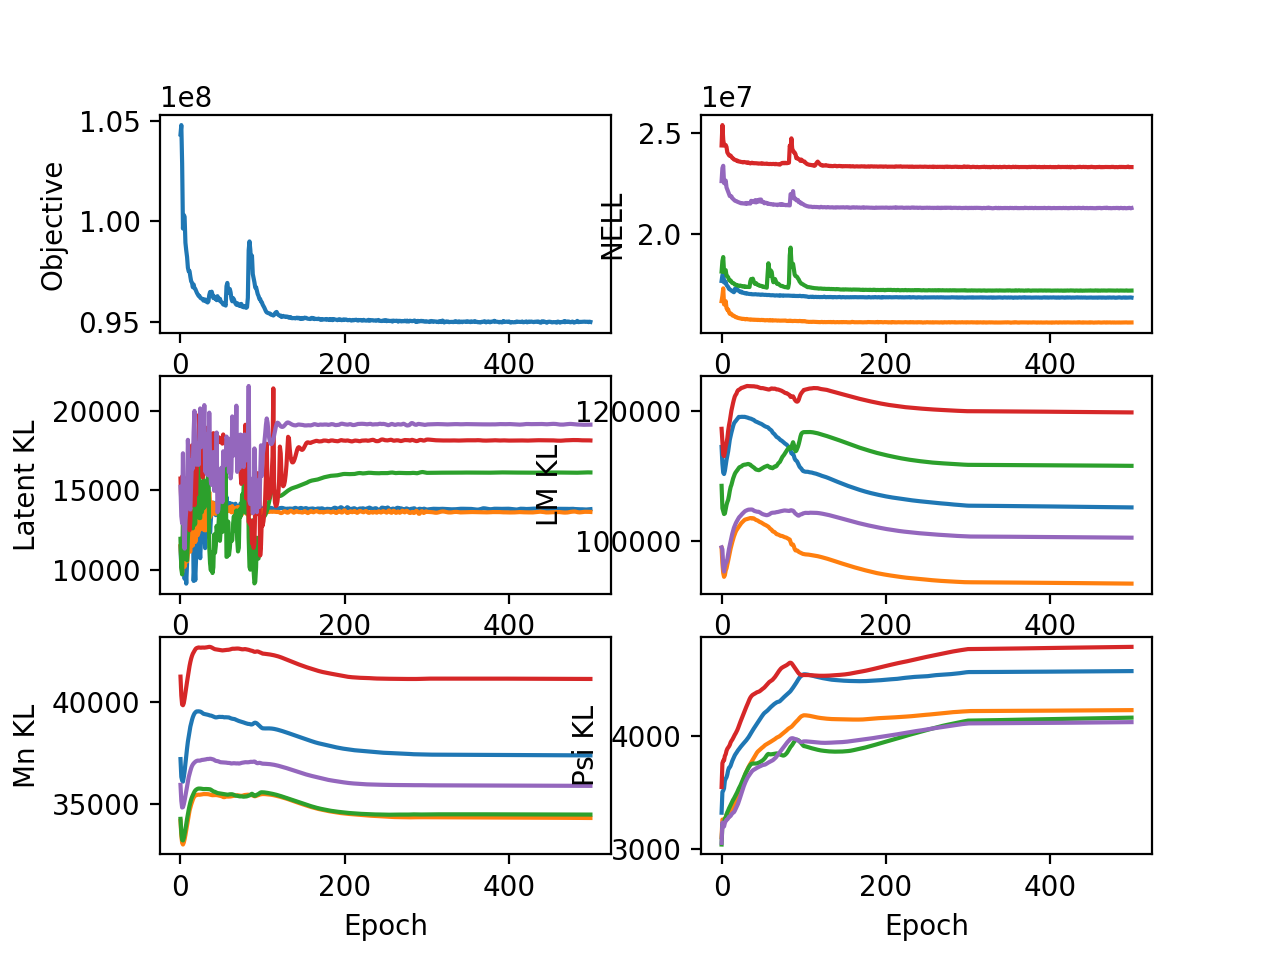

In [30]:
fitter.plot_log(logs[0])

## Look at model fits

In [31]:
exam_mdl = 2

<IPython.core.display.Javascript object>


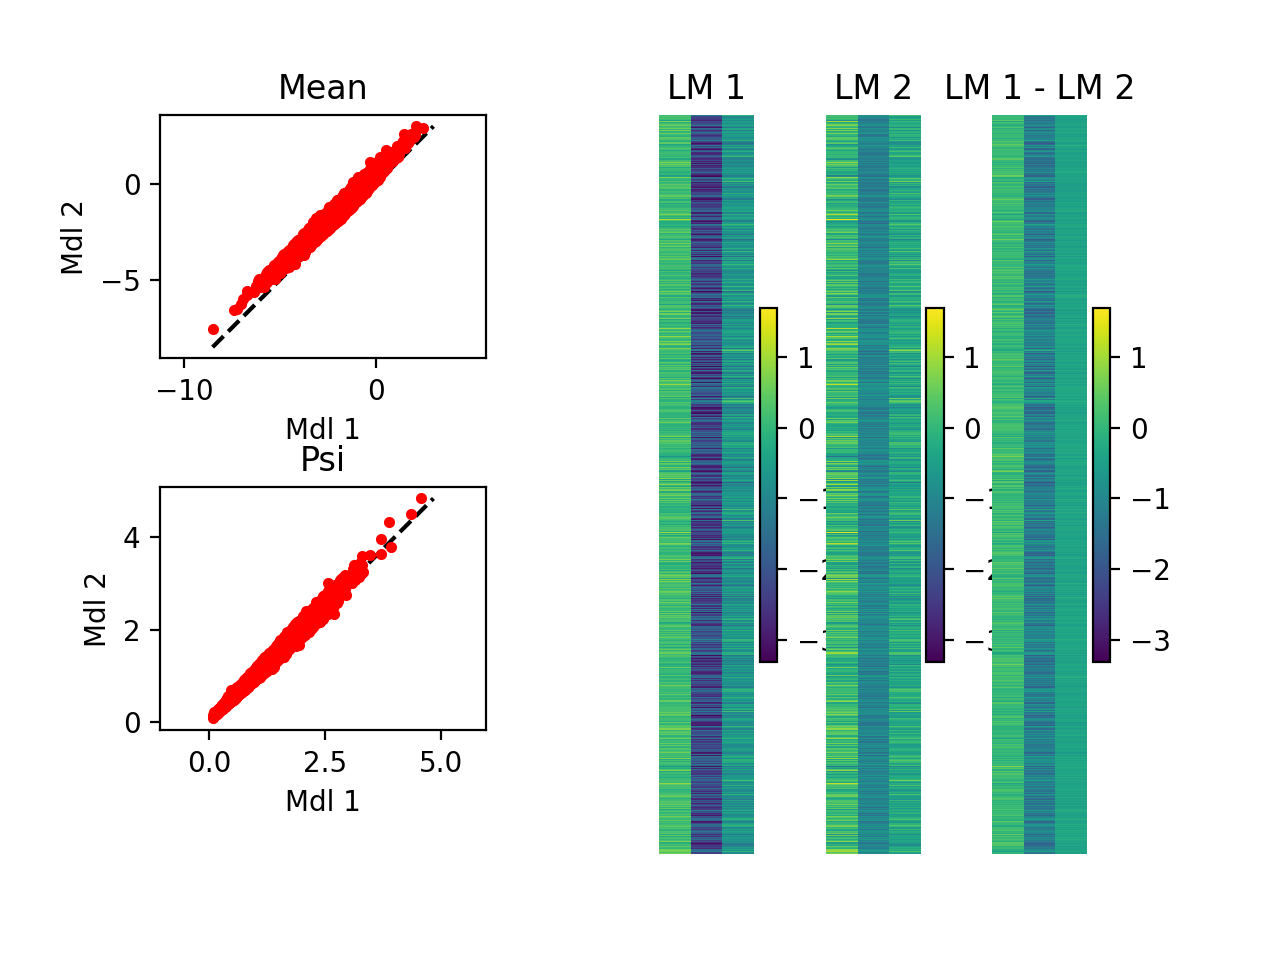

(10107, 3)


In [32]:
fit_lm = vi_collections[exam_mdl].posteriors.lm_post(ind_props[exam_mdl]).detach().squeeze()
fit_mn = vi_collections[exam_mdl].posteriors.mn_post(ind_props[exam_mdl]).detach().squeeze()
fit_psi = vi_collections[exam_mdl].posteriors.psi_post.mode(ind_props[exam_mdl]).detach().squeeze()
#fit_psi = vi_collections[exam_mdl].mdl.psi

cmp_mdl = FAMdl(lm=fit_lm, mn=fit_mn, psi=fit_psi)
true_mdl = ind_true_fa_mdls[exam_mdl]

plt.figure()
true_mdl.compare_models(true_mdl, cmp_mdl)

### Visualize paraemters of the true prior distributions over the loading matrices

<IPython.core.display.Javascript object>


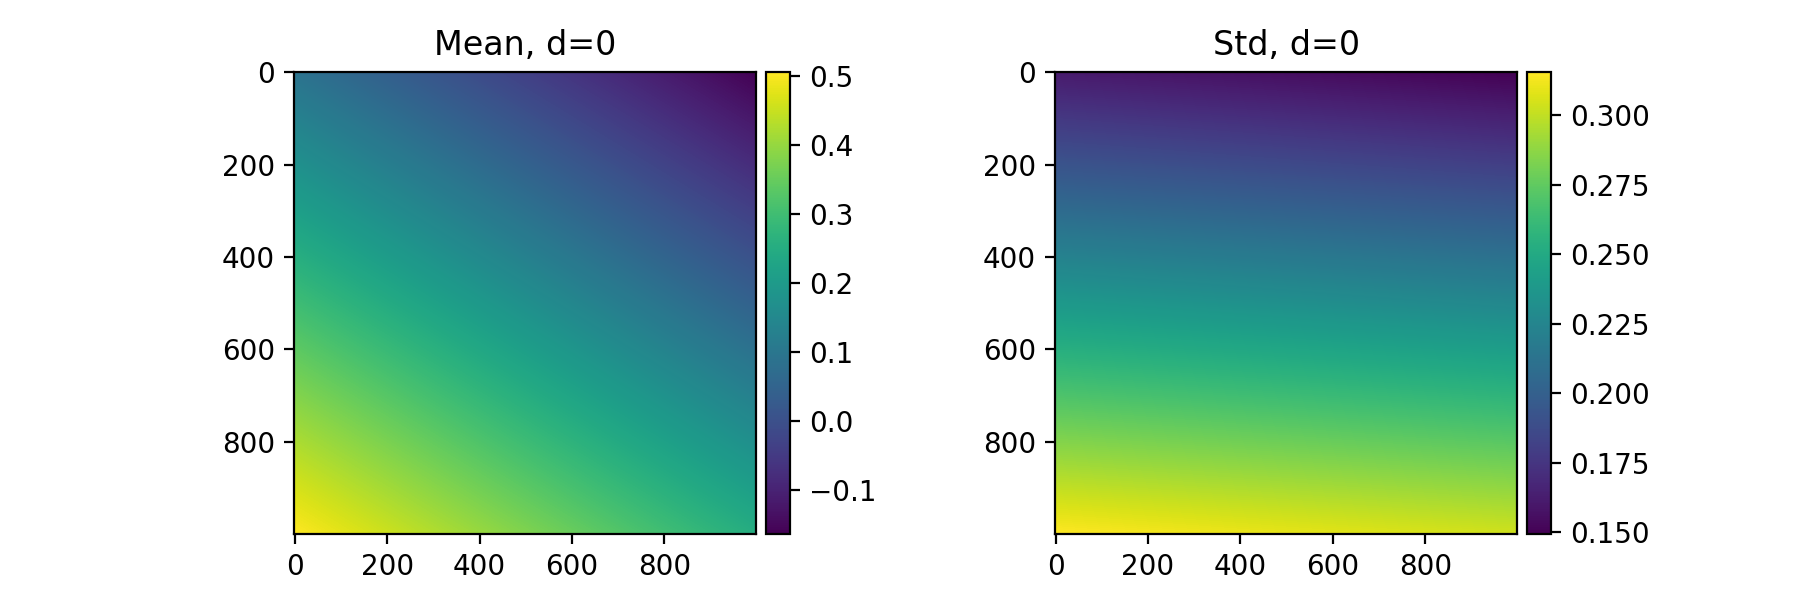

<IPython.core.display.Javascript object>


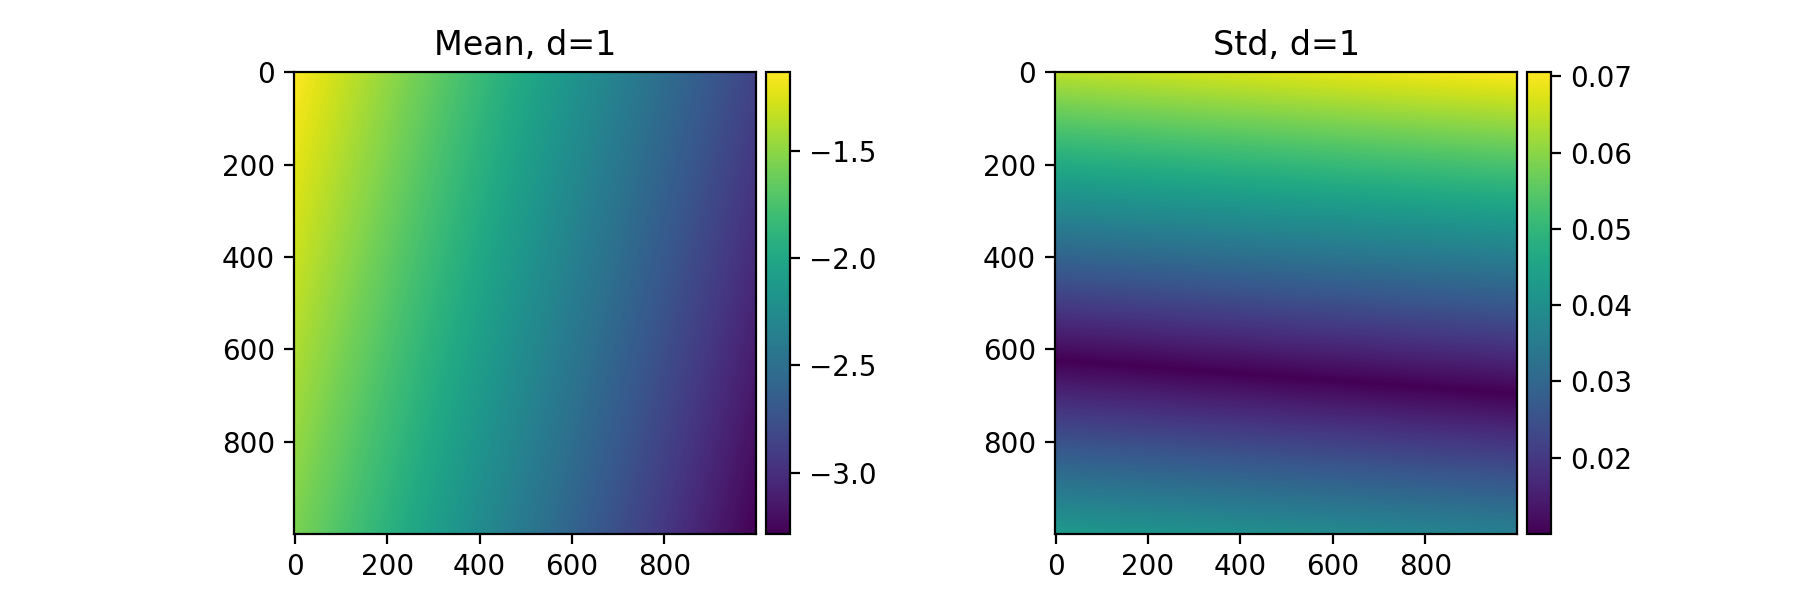

<IPython.core.display.Javascript object>


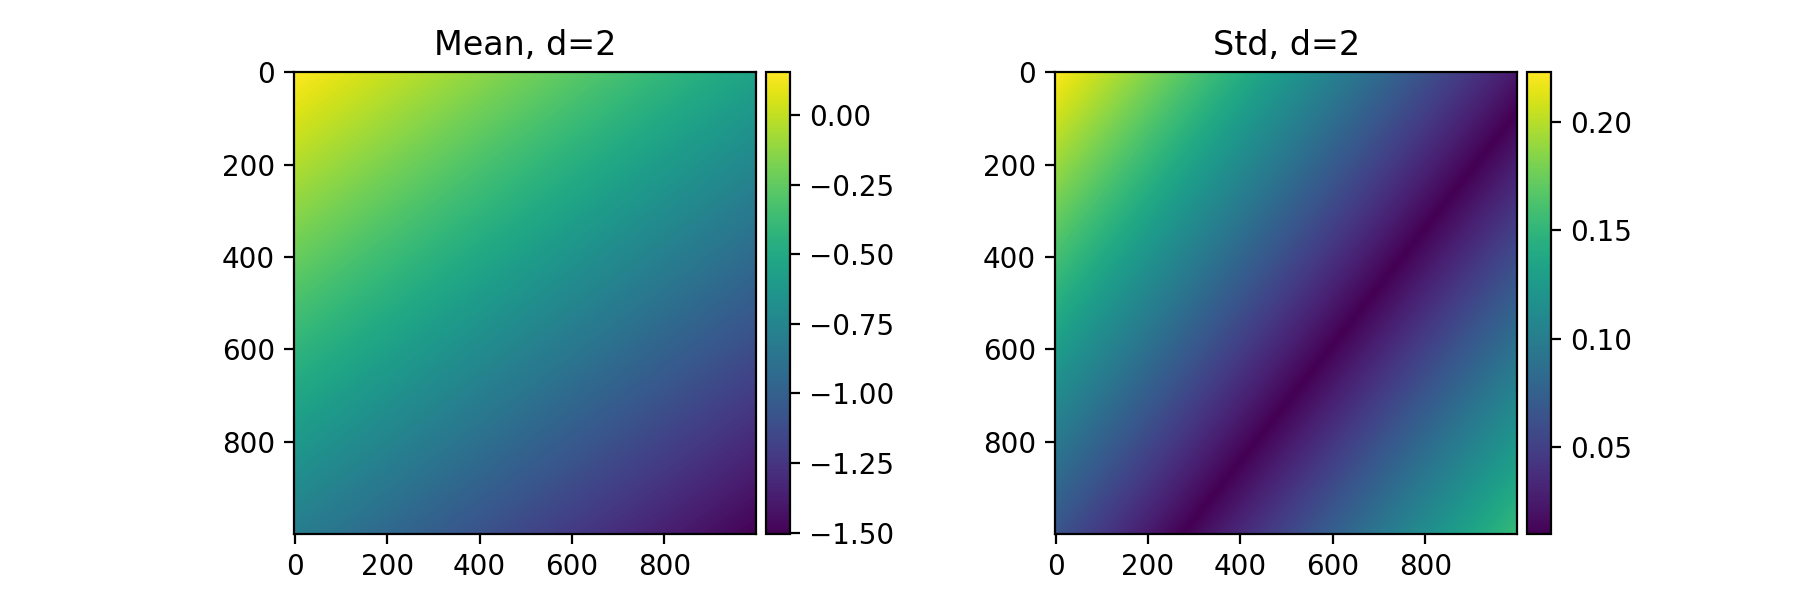

In [16]:
for d in range(n_latent_vars):
    plt.figure(figsize=(9,3))
    plot_torch_dist(mn_f=true_priors.lm_prior.mn_f, std_f=true_priors.lm_prior.std_f, vis_dim=d, 
                    extra_title_str = ', d=' + str(d))

### Visualize paraemters of the fit prior distributions over the loading matrices

In [17]:
rnd_vls = torch.rand(1000,2)
o = optimal_orthonormal_transform(true_priors.lm_prior(rnd_vls).detach().numpy(), 
                                  fit_priors.lm_prior(rnd_vls).detach().numpy())


class std_calculator(torch.nn.Module):
    # A wrapper module for calculating standard deviation of conditional matrix product distributions
    
    def __init__(self, m):
        super().__init__()
        self.m = m
        
    def forward(self, x):
        # Calculate standard deviation
        return torch.cat([d.std_f(x) for d in self.m.dists], dim=1)
        
std_calc = std_calculator(fit_priors.lm_prior)
    
fit_lm_mn_fcn = MeanFcnTransformer(o=o.transpose(), f=fit_priors.lm_prior.forward)
fit_lm_std_fcn = StdFcnTransformer(o=o.transpose(), f=std_calc.forward)

<IPython.core.display.Javascript object>


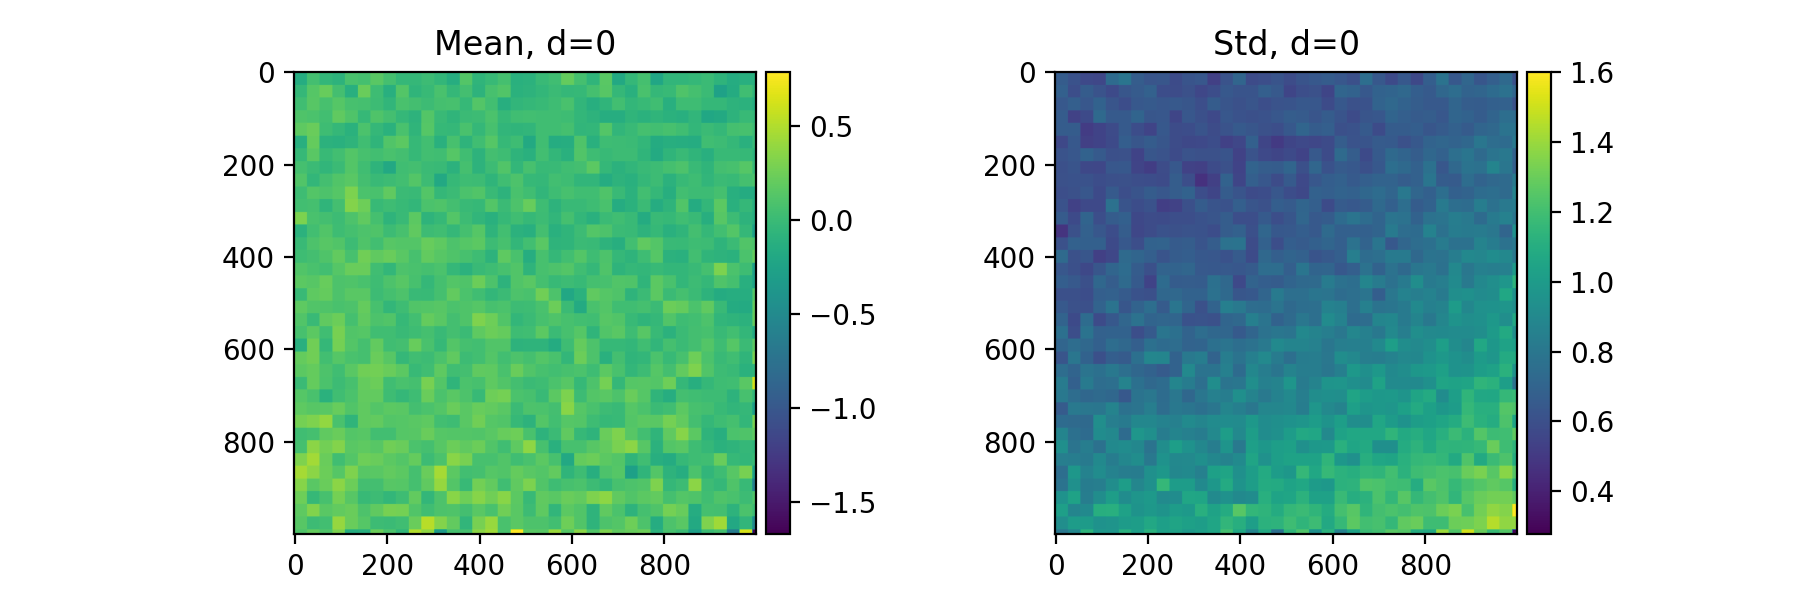

torch.Size([1000000, 3])


<IPython.core.display.Javascript object>


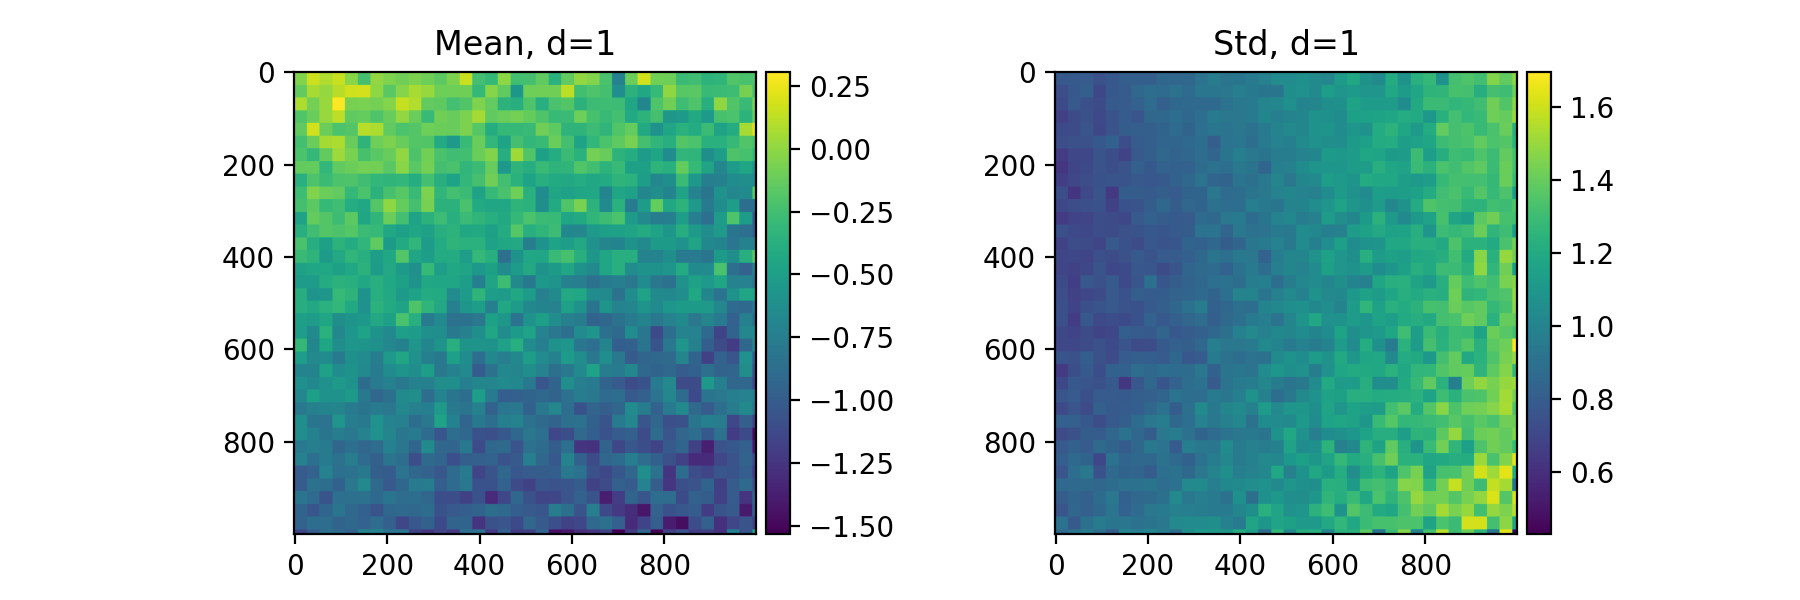

torch.Size([1000000, 3])


<IPython.core.display.Javascript object>


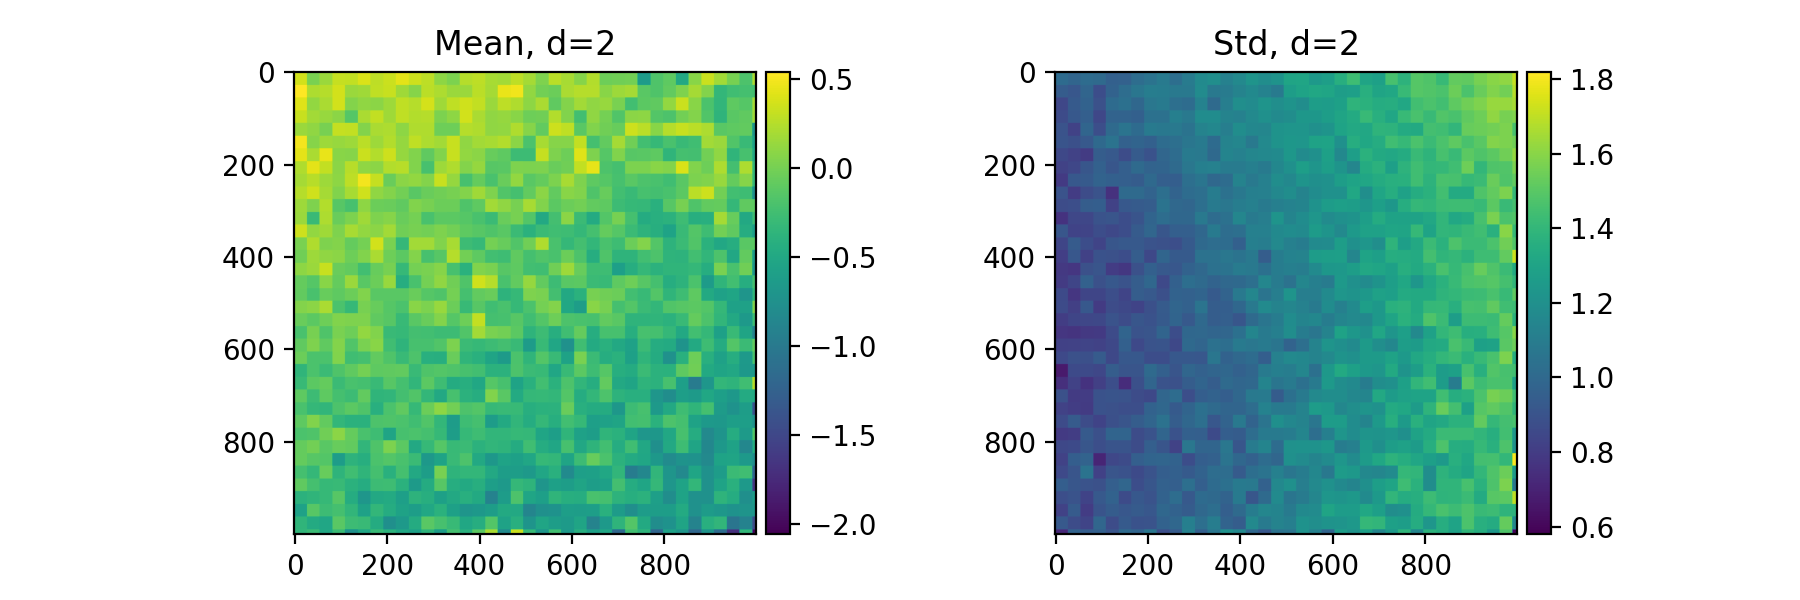

torch.Size([1000000, 3])


In [18]:
for d in range(n_latent_vars):
    plt.figure(figsize=(9,3))
    plot_torch_dist(mn_f=fit_lm_mn_fcn, std_f=fit_lm_std_fcn, vis_dim=d, 
                    extra_title_str = ', d=' + str(d))

### Visualize parameters of the true prior distribution over the means

<IPython.core.display.Javascript object>


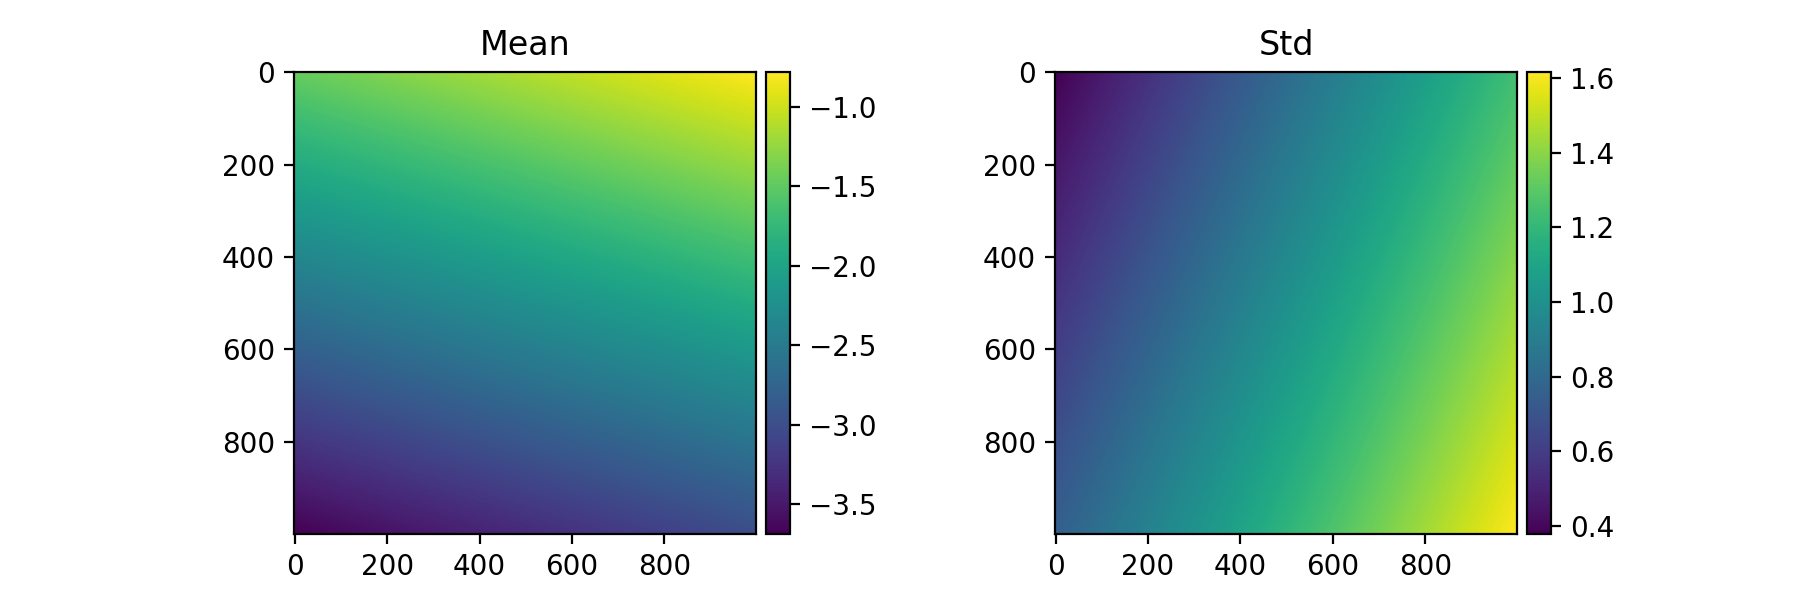

In [19]:
plt.figure(figsize=(9,3))
plot_torch_dist(mn_f=true_priors.mn_prior.mn_f, std_f=true_priors.mn_prior.std_f)

### Visualize parameters of the fit prior distribution over the means

<IPython.core.display.Javascript object>


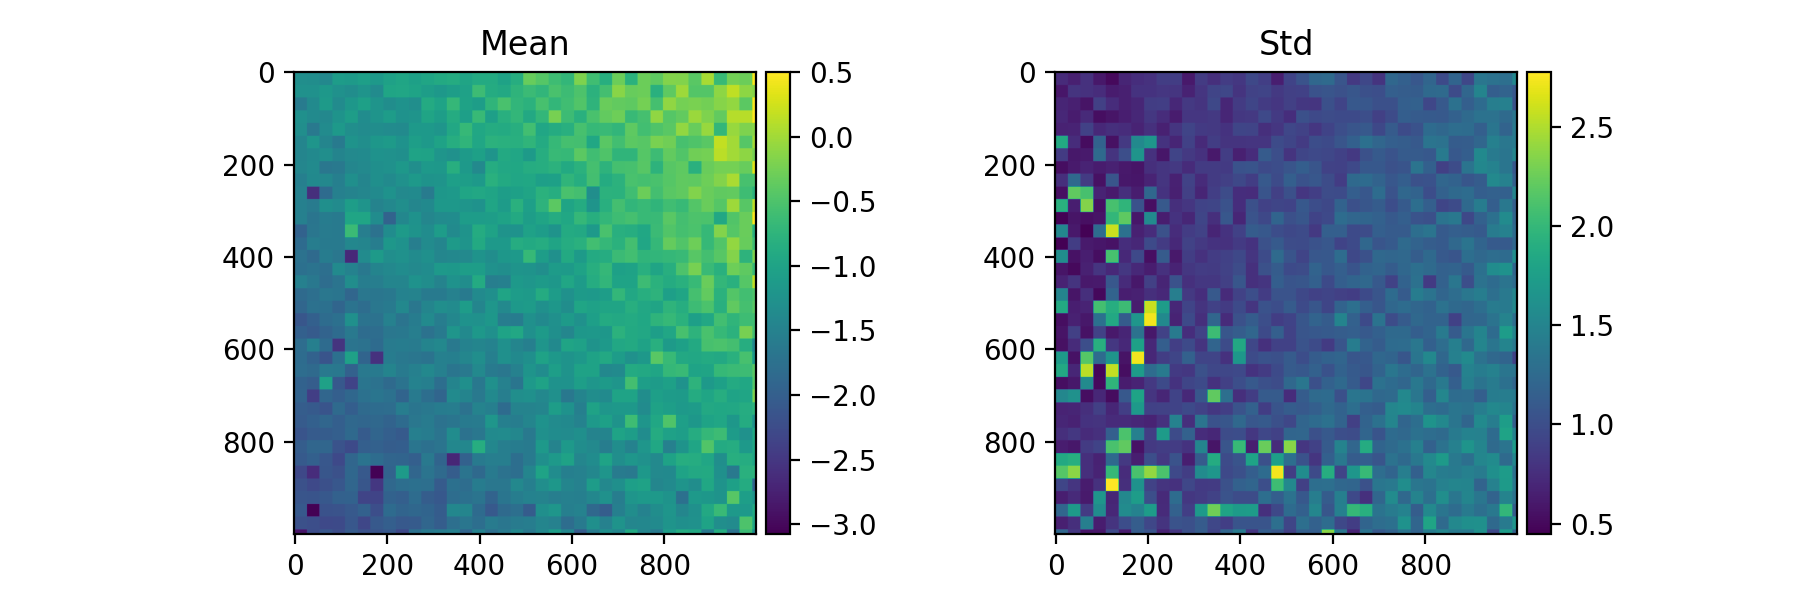

In [20]:
plt.figure(figsize=(9,3))
plot_torch_dist(mn_f=fit_priors.mn_prior.mn_f, std_f=fit_priors.mn_prior.std_f)

### Visualize parameters of the true prior distribution over private variances

<IPython.core.display.Javascript object>


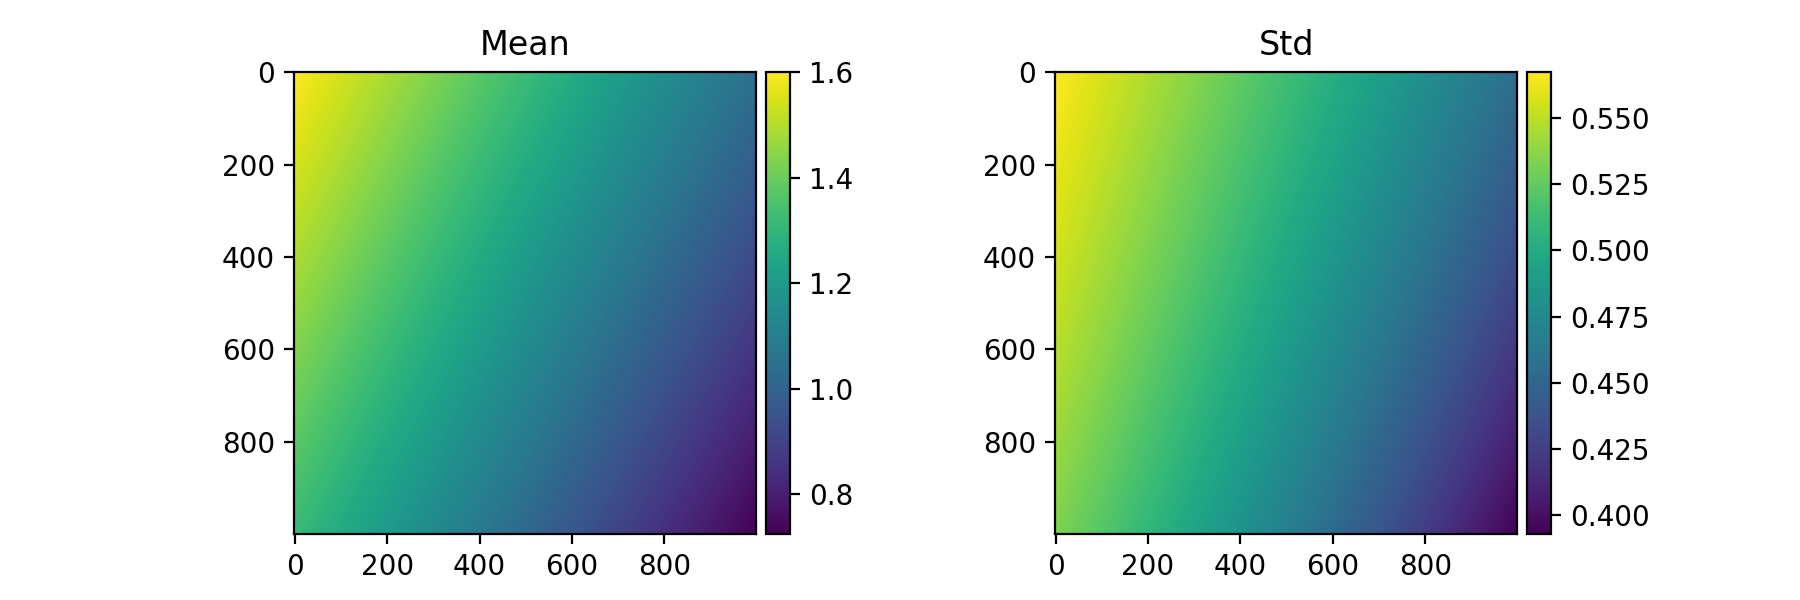

In [21]:
plt.figure(figsize=(9,3))
plot_torch_dist(mn_f=true_priors.psi_prior.forward, std_f=true_priors.psi_prior.std)

### Visualize parameters of the fit prior distribution over private variances

<IPython.core.display.Javascript object>


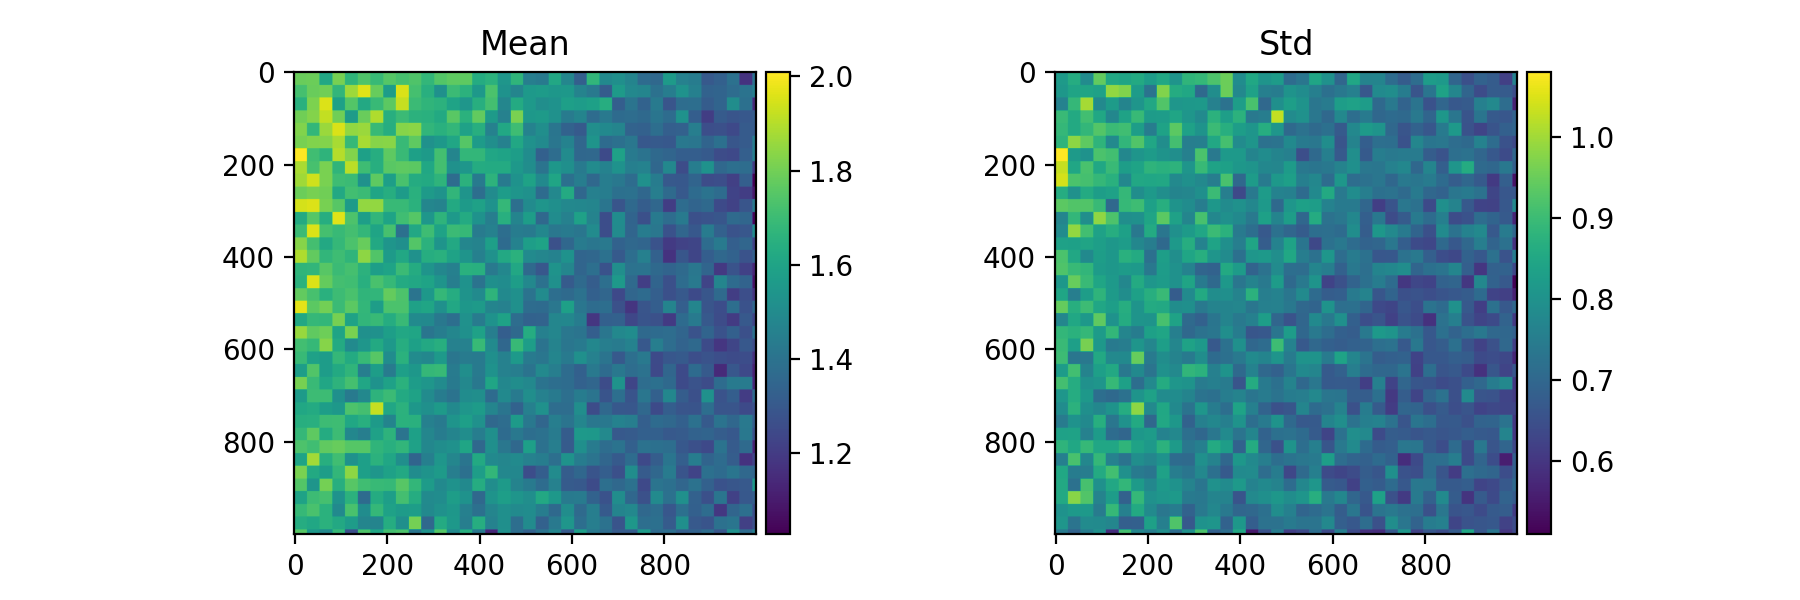

In [22]:
plt.figure(figsize=(9,3))
plot_torch_dist(mn_f=fit_priors.psi_prior.forward, std_f=fit_priors.psi_prior.std)

## Visualize latent estimates for an example model

In [33]:
ex_s = 0

In [34]:
# Learn transformation to put estimated latents into same space as true latents
with torch.no_grad():
    true_lm = ind_true_fa_mdls[ex_s].lm.numpy()
    est_lm = fit_posteriors[ex_s].lm_post(ind_props[ex_s]).numpy()
    o = optimal_orthonormal_transform(true_lm, est_lm)

In [35]:
# Get estimated latents in the right space
est_latents = np.matmul(fit_posteriors[ex_s].latent_post.mns.detach().numpy(), o)

In [26]:
# Visualize latents
true_latents = ind_data[ex_s][0].numpy()

<IPython.core.display.Javascript object>


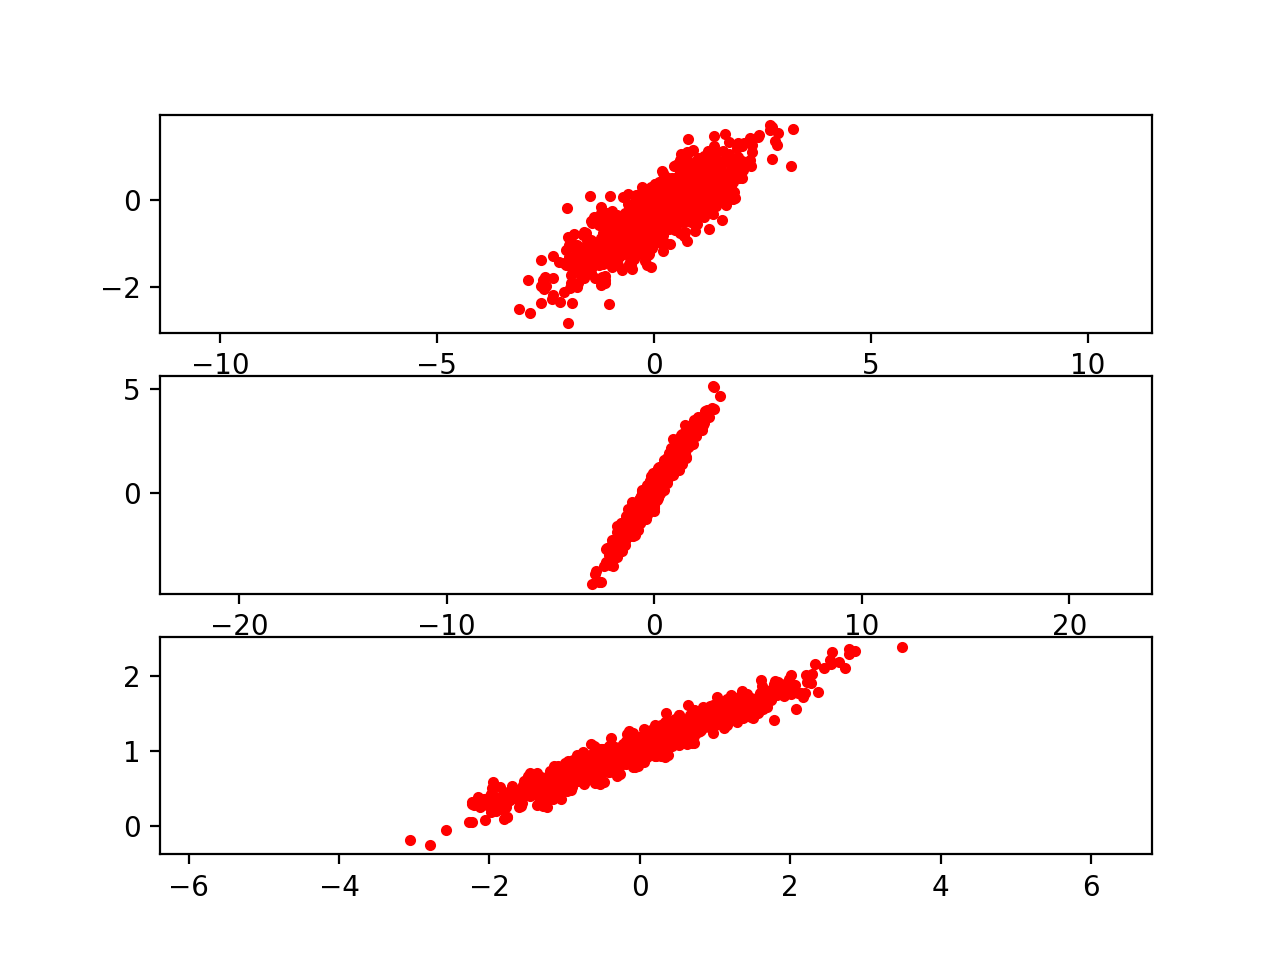

In [27]:
plt.figure()
for l_i in range(n_latent_vars):
    ax = plt.subplot(n_latent_vars, 1, l_i+1)
    plt.plot(true_latents[:, l_i], est_latents[:, l_i], 'r.')
    ax.axis('equal')